In [126]:
import sklearn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns
# from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
import pickle
import joblib
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [127]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [146]:
import os
directory=os.getcwd().replace('notebooks','data\\output\\census_elections\\')
model_directory=os.getcwd().replace('notebooks','models\\')
filename="census_election_totals_and_percent_data.csv"
full_name=f"{directory}{filename}"
full_df=pd.read_csv(full_name).set_index(['District_Name_x','Electoral_District_Number'])
del full_df['employment_employed']
del full_df['employment_unemployed']
del full_df['employment_not_in_the_labour_force']
del full_df['District_Name_y']
# del full_df['District_Name_x']
del full_df['employment_employment_rate']
del full_df['employment_participation_rate']
del full_df['ALT_GEO_CODE_y']
del full_df['ALT_GEO_CODE_x']
y = full_df['employment_unemployment_rate']
X = full_df.drop('employment_unemployment_rate',1).fillna(0)
categorical_fields=X.select_dtypes(include='object').columns
X=pd.get_dummies(data=X,columns=categorical_fields,drop_first=True)
output_directory=directory.replace('\\output\\census_elections\\','\\output\\model_output\\')
# CV_feat_importances_df=pd.read_csv(f'{output_directory}CV_percent_feat_importances_df.csv')
CV_feat_importances_df=pd.read_csv(f'{output_directory}CV_feat_importances_df.csv')

important_columns=list(CV_feat_importances_df.nlargest(50,'score')['fields'])
X=X[important_columns]
uncorrelated_columns=list(calc_vif(X).nsmallest(columns='VIF',n=15)['variables'])
X=X[uncorrelated_columns]
calc_vif(X).sort_values('VIF').reset_index()
X = sm.add_constant(X) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42).fit(X)
X['cluster']=kmeans.predict(X)
X=X.reset_index().set_index(['cluster','District_Name_x','Electoral_District_Number'])
print(print_model)
# del full_df['ALT_GEO_CODE']

                                 OLS Regression Results                                 
Dep. Variable:     employment_unemployment_rate   R-squared:                       0.449
Model:                                      OLS   Adj. R-squared:                  0.423
Method:                           Least Squares   F-statistic:                     17.48
Date:                          Wed, 22 Sep 2021   Prob (F-statistic):           1.77e-33
Time:                                  23:34:21   Log-Likelihood:                -734.17
No. Observations:                           338   AIC:                             1500.
Df Residuals:                               322   BIC:                             1562.
Df Model:                                    15                                         
Covariance Type:                      nonrobust                                         
                                                                                     coef    std err          

In [136]:
X

,District_Name_x,Electoral_District_Number,const,education_subject_percent_other,2015-2019_EOE_Percent_Change_Percent_Riding_Votes_NDP-New-Democratic-Party,2015-2019_Absolute_Change_Percent_Riding_Votes_Green-Party,home_type_percent_semi-detached_house,2015-2019_EOE_Percent_Change_Liberal_Votes,population_density_per_square_kilometre,ethnic_filipino,population_percentage_change_2011_to_2016,2019_Percent_Riding_Votes_Green-Party,ethnic_latin_american,_of_tenant_households_in_subsidized_housing,immigrant_category_percent_non-permanent_residents,industry_71_arts_entertainment_and_recreation,median_value_of_dwellings_($),industry_31-33_manufacturing,education_level_earned_doctorate
cluster,,,,,,,,,,,,,,,,,,,
0,Avalon,10001,1.000,0.000,0.197,0.048,0.014,-0.187,13.400,65.000,6.000,0.054,50.000,12.900,0.001,495.000,255983.000,3065.000,105.000
0,Bonavista--Burin--Trinity,10002,1.000,0.000,0.644,0.020,0.012,-0.488,4.400,70.000,-3.400,0.029,10.000,20.700,0.002,495.000,139367.000,4980.000,30.000
0,Coast of Bays--Central--Notre Dame,10003,1.000,0.000,1.014,0.032,0.037,-0.377,2.000,80.000,-0.500,0.040,25.000,23.400,0.001,350.000,149507.000,2155.000,40.000
0,Labrador,10004,1.000,0.000,0.703,0.020,0.120,-0.454,0.100,425.000,1.800,0.020,25.000,26.800,0.010,165.000,240486.000,565.000,20.000
0,Long Range Mountains,10005,1.000,0.000,0.748,0.008,0.036,-0.411,2.300,155.000,-1.200,0.035,10.000,24.900,0.002,465.000,160311.000,2590.000,120.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,Victoria,59041,1.000,0.000,-0.214,-0.030,0.023,0.879,2907.900,2045.000,5.600,0.299,980.000,12.500,0.030,1905.000,601878.000,1780.000,1515.000
1,West Vancouver--Sunshine Coast--Sea to Sky Cou...,59042,1.000,0.000,0.409,0.135,0.038,-0.375,9.200,2010.000,5.500,0.224,635.000,11.500,0.028,2375.000,800447.000,2350.000,830.000
2,Yukon,60001,1.000,0.000,0.130,0.078,0.077,-0.354,0.100,1195.000,5.800,0.105,135.000,25.100,0.013,595.000,358721.000,340.000,110.000


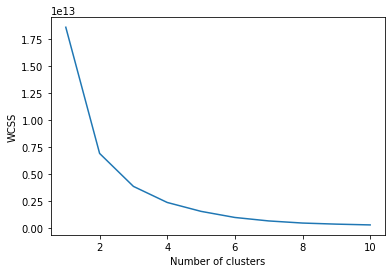

In [130]:
from sklearn.cluster import KMeans
wcss = [] 
for i in range(1, 11): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X) 
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show()

In [131]:

X

,,const,education_subject_percent_other,2015-2019_EOE_Percent_Change_Percent_Riding_Votes_NDP-New-Democratic-Party,2015-2019_Absolute_Change_Percent_Riding_Votes_Green-Party,home_type_percent_semi-detached_house,2015-2019_EOE_Percent_Change_Liberal_Votes,population_density_per_square_kilometre,ethnic_filipino,population_percentage_change_2011_to_2016,2019_Percent_Riding_Votes_Green-Party,ethnic_latin_american,_of_tenant_households_in_subsidized_housing,immigrant_category_percent_non-permanent_residents,industry_71_arts_entertainment_and_recreation,median_value_of_dwellings_($),industry_31-33_manufacturing,education_level_earned_doctorate,cluster
District_Name_x,Electoral_District_Number,,,,,,,,,,,,,,,,,,
Avalon,10001,1.000,0.000,0.197,0.048,0.014,-0.187,13.400,65.000,6.000,0.054,50.000,12.900,0.001,495.000,255983.000,3065.000,105.000,0
Bonavista--Burin--Trinity,10002,1.000,0.000,0.644,0.020,0.012,-0.488,4.400,70.000,-3.400,0.029,10.000,20.700,0.002,495.000,139367.000,4980.000,30.000,0
Coast of Bays--Central--Notre Dame,10003,1.000,0.000,1.014,0.032,0.037,-0.377,2.000,80.000,-0.500,0.040,25.000,23.400,0.001,350.000,149507.000,2155.000,40.000,0
Labrador,10004,1.000,0.000,0.703,0.020,0.120,-0.454,0.100,425.000,1.800,0.020,25.000,26.800,0.010,165.000,240486.000,565.000,20.000,0
Long Range Mountains,10005,1.000,0.000,0.748,0.008,0.036,-0.411,2.300,155.000,-1.200,0.035,10.000,24.900,0.002,465.000,160311.000,2590.000,120.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Victoria,59041,1.000,0.000,-0.214,-0.030,0.023,0.879,2907.900,2045.000,5.600,0.299,980.000,12.500,0.030,1905.000,601878.000,1780.000,1515.000,1
West Vancouver--Sunshine Coast--Sea to Sky Country,59042,1.000,0.000,0.409,0.135,0.038,-0.375,9.200,2010.000,5.500,0.224,635.000,11.500,0.028,2375.000,800447.000,2350.000,830.000,1
Yukon,60001,1.000,0.000,0.130,0.078,0.077,-0.354,0.100,1195.000,5.800,0.105,135.000,25.100,0.013,595.000,358721.000,340.000,110.000,2


In [132]:
X.groupby(['cluster']).mean()

,const,education_subject_percent_other,2015-2019_EOE_Percent_Change_Percent_Riding_Votes_NDP-New-Democratic-Party,2015-2019_Absolute_Change_Percent_Riding_Votes_Green-Party,home_type_percent_semi-detached_house,2015-2019_EOE_Percent_Change_Liberal_Votes,population_density_per_square_kilometre,ethnic_filipino,population_percentage_change_2011_to_2016,2019_Percent_Riding_Votes_Green-Party,ethnic_latin_american,_of_tenant_households_in_subsidized_housing,immigrant_category_percent_non-permanent_residents,industry_71_arts_entertainment_and_recreation,median_value_of_dwellings_($),industry_31-33_manufacturing,education_level_earned_doctorate
cluster,,,,,,,,,,,,,,,,,
0,1.000,0.000,-0.177,0.034,0.047,-0.221,428.945,916.618,2.622,0.063,675.231,15.053,0.006,940.867,235001.000,4770.116,288.873
1,1.000,0.000,0.081,0.027,0.060,-0.022,2997.196,4603.529,6.847,0.072,1956.471,12.220,0.025,1393.039,727543.373,4423.235,860.588
2,1.000,0.000,0.062,0.030,0.053,-0.137,2177.646,3240.093,7.748,0.063,2060.421,11.964,0.021,1264.019,429449.047,4920.093,678.271
3,1.000,0.000,0.242,0.039,0.026,-0.190,3385.171,5740.000,3.014,0.079,1468.571,10.700,0.039,1525.714,1322707.429,2763.571,1322.143


In [133]:
X.cluster.value_counts()

0    173
2    107
1     51
3      7
Name: cluster, dtype: int64

,District_Name_x,Electoral_District_Number,const,education_subject_percent_other,2015-2019_EOE_Percent_Change_Percent_Riding_Votes_NDP-New-Democratic-Party,2015-2019_Absolute_Change_Percent_Riding_Votes_Green-Party,home_type_percent_semi-detached_house,2015-2019_EOE_Percent_Change_Liberal_Votes,population_density_per_square_kilometre,ethnic_filipino,population_percentage_change_2011_to_2016,2019_Percent_Riding_Votes_Green-Party,ethnic_latin_american,_of_tenant_households_in_subsidized_housing,immigrant_category_percent_non-permanent_residents,industry_71_arts_entertainment_and_recreation,median_value_of_dwellings_($),industry_31-33_manufacturing,education_level_earned_doctorate
cluster,,,,,,,,,,,,,,,,,,,
0,Avalon,10001,1.000,0.000,0.197,0.048,0.014,-0.187,13.400,65.000,6.000,0.054,50.000,12.900,0.001,495.000,255983.000,3065.000,105.000
0,Bonavista--Burin--Trinity,10002,1.000,0.000,0.644,0.020,0.012,-0.488,4.400,70.000,-3.400,0.029,10.000,20.700,0.002,495.000,139367.000,4980.000,30.000
0,Coast of Bays--Central--Notre Dame,10003,1.000,0.000,1.014,0.032,0.037,-0.377,2.000,80.000,-0.500,0.040,25.000,23.400,0.001,350.000,149507.000,2155.000,40.000
0,Labrador,10004,1.000,0.000,0.703,0.020,0.120,-0.454,0.100,425.000,1.800,0.020,25.000,26.800,0.010,165.000,240486.000,565.000,20.000
0,Long Range Mountains,10005,1.000,0.000,0.748,0.008,0.036,-0.411,2.300,155.000,-1.200,0.035,10.000,24.900,0.002,465.000,160311.000,2590.000,120.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,Victoria,59041,1.000,0.000,-0.214,-0.030,0.023,0.879,2907.900,2045.000,5.600,0.299,980.000,12.500,0.030,1905.000,601878.000,1780.000,1515.000
1,West Vancouver--Sunshine Coast--Sea to Sky Cou...,59042,1.000,0.000,0.409,0.135,0.038,-0.375,9.200,2010.000,5.500,0.224,635.000,11.500,0.028,2375.000,800447.000,2350.000,830.000
2,Yukon,60001,1.000,0.000,0.130,0.078,0.077,-0.354,0.100,1195.000,5.800,0.105,135.000,25.100,0.013,595.000,358721.000,340.000,110.000


In [ ]:
full_df.columns[full_df.isna().any()].tolist()

In [ ]:
pd.options.display.max_columns = None
full_df

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
model=RandomForestRegressor(random_state=12)
model.fit(X_train,y_train)

In [ ]:
y_pred=model.predict(X_test)
y_pred

In [ ]:
mean_squared_error(y_test,y_pred)

In [ ]:
model.feature_importances_

In [ ]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.index.name='fields'
feat_importances_df=feat_importances.to_frame(name='score').sort_values('score',ascending=False).reset_index()#.rename('index','fields')#,'0':'score'})
feat_importances_df.head(60)# feat_importances.nlargest(20)#.plot(kind='barh')

In [ ]:
model.get_params()

In [ ]:
predict_df=y_test.to_frame()
predict_df['predict_unemployment_rate']=y_pred
predict_df=predict_df.reset_index()

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(20, 110, num = 4)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=3, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

In [ ]:
rf_random.best_params_

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [ ]:
base_accuracy = evaluate(model, X_test, y_test)

In [ ]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

In [ ]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [ ]:
mean_squared_error(y_test,y_pred)

In [ ]:
CV_feat_importances = pd.Series(best_random.feature_importances_, index=X.columns)
CV_feat_importances.index.name='fields'
CV_feat_importances_df=feat_importances.to_frame(name='score').sort_values('score',ascending=False).reset_index()#.rename('index','fields')#,'0':'score'})
CV_feat_importances_df.head(60)

In [ ]:
CV_predict_df=y_test.to_frame()
CV_predict_df['predict_unemployment_rate']=y_pred
CV_predict_df=CV_predict_df.reset_index()
CV_predict_df

In [ ]:
output_directory=directory.replace('\\output\\census_elections\\','\\output\\model_output\\')
CV_feat_importances_df.to_csv(f'{output_directory}CV_feat_importances_df.csv')
CV_predict_df.to_csv(f'{output_directory}CV_predict_df.csv')
feat_importances_df.to_csv(f'{output_directory}feat_importances_df.csv')
predict_df.to_csv(f'{output_directory}predict_df.csv')
print(directory)
print(output_directory)

print(model_directory)
model_directory=directory.replace('\\data\\output\\census_elections\\','\\models\\')
joblib.dump(model, f'{model_directory}base_rf_model.pkl', compress=9)
joblib.dump(best_random, f'{model_directory}best_rf_model.pkl', compress=9)